### ECG waveform with digital filter- Application of Chebyshev and Moving Average filter.
<b> Author: Jay Gautam, Darmstadt Germany.

Learning objectives:
1. ECG (also called as EKG) signal filtering
2. Chebyshev Type II bandstop filter to remove 50Hz noise.
3. Chebyshev Type II lowpass filter to filter the high frequency components (above 200Hz)
4. Apply Moving average filter to extract the each components of the ECG signal.
    
Requirements:
    1. The data in .csv format is observed using measurement device. It has 8000 samples with 2 seconds time duration. 
    2. Sampling frequency = 4000Hz = 4kHz.

ECG or EKG signal: Bioelectrical signal. Heart's electrical activity represented in terms of the ECG signal.

Picture credit: https://doi.org/10.1016/j.mehy.2019.109515

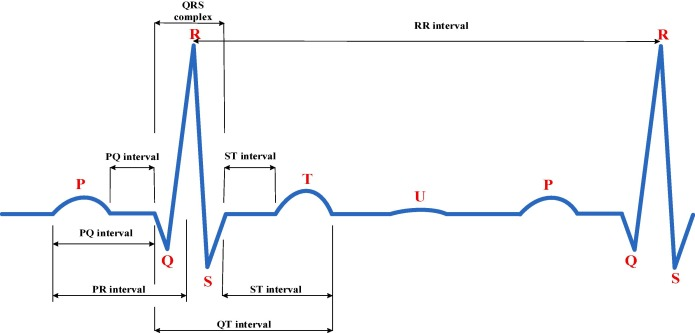


In [49]:
# Import the relevant library.

from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from scipy.fftpack import fft # For frequency domain represenatation. Fast Fourier transfomation.
from scipy import signal

In [50]:
# Original data frame and calculation of sampling frequency.

ekgDF = pd.read_csv('ecg.csv') # Original data.
# ekgDF.describe()
# ekgDF.head()
# ekgDF.info

samplingFreq = 1/(ekgDF['Time (s)'][22]-ekgDF['Time (s)'][21])
print ('Sampling frequency = ', samplingFreq, 'Hz')

Sampling frequency =  3999.9999999986644 Hz


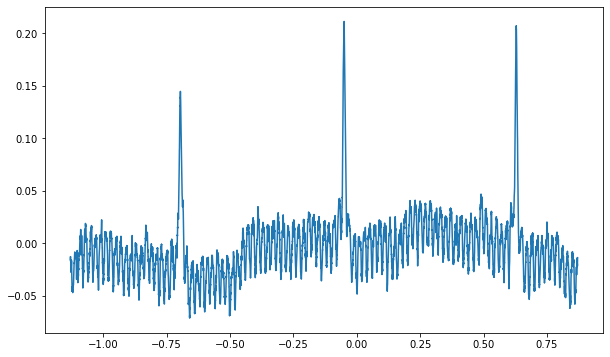

In [51]:
# Time Domain representation of the ECG signal.
matplotlib.rc('figure', figsize=(10, 6))
plt.plot(ekgDF['Time (s)'],ekgDF['Channel 1 (V)'])

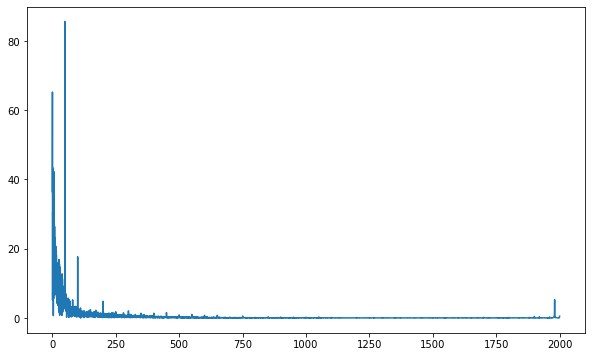

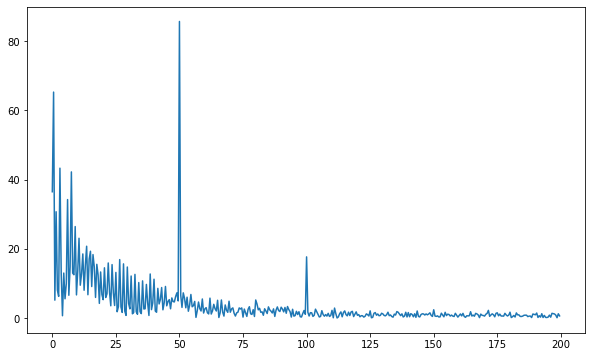

In [52]:
# Frequency Domain representation of the ECG signal using FFT on the ECG data.
# According to the Nyquist theorem, the nyquist frequency = maximum frequency to be measured = (sampling frequency)/2
# so, Max frequency components observed on the frequency spectrum = 2000 Hz.
# FFT len is half size of the length of the signal.

ekgData = ekgDF['Channel 1 (V)'].values # to get the value in array format, not the index.
# len(ekgData)
fftData = np.abs( fft(ekgData) ) # FFT, len(fftData) = 8000
fftLen = int(len(fftData) / 2)  # fftlen = 4000
freqs = np.linspace(0,samplingFreq/2, fftLen ) # len(freqs) = 4000

# Visual representation.
matplotlib.rc('figure', figsize=(10, 6))

plt.figure()
plt.plot( freqs, fftData[0:fftLen] )

plt.figure()
plt.plot( freqs[0:400], fftData[0:400] )

# plt.figure()
# plt.plot( freqs[0:200], fftData[0:200] )

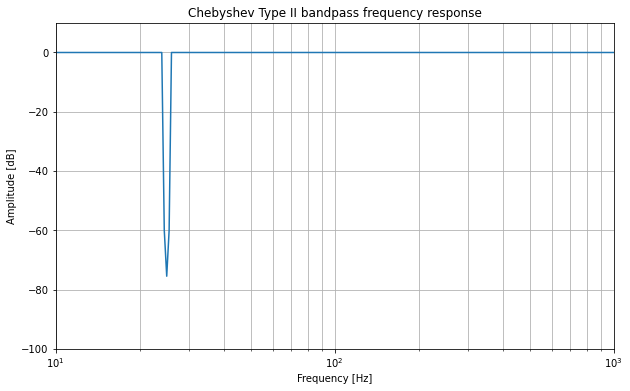

In [53]:
## IIR filter- Chebyshev Type II bandstop filter to filter the high noise seen at 50 Hz in the above signal.
# Chebyshev Type II filter, filter coefficients = 17, gain = -60 dB, frequency stop band = 49 - 51 Hz.

# details of the function iirfilter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html
# sos = Second-order sections representation of the IIR filter.

sos = signal.iirfilter(17, [49, 51], rs=60, btype='bandstop',
                        analog=False, ftype='cheby2', fs=4000,
                        output='sos')

# Details of the function sosfreqz: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfreqz.html
# w = The frequencies at which h was computed
# h = The frequency response, as complex numbers.

w, h = signal.sosfreqz(sos, 2000, fs=2000)

# Plot of the IIR filter.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('Chebyshev Type II bandpass frequency response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

In [54]:
## filtering the noise from the ECG signal at 50 Hz.
# Details of the function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html

ekgFiltered = signal.sosfilt(sos, ekgData) # Filtering the ECG data with IIR filter.


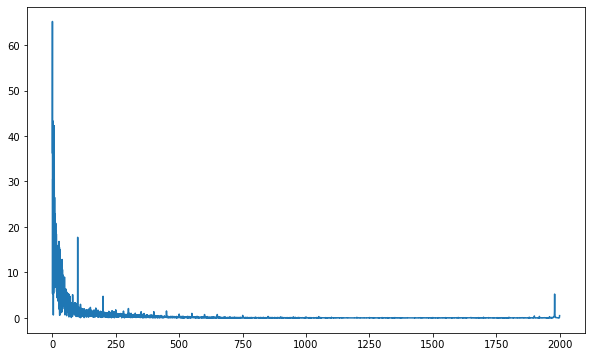

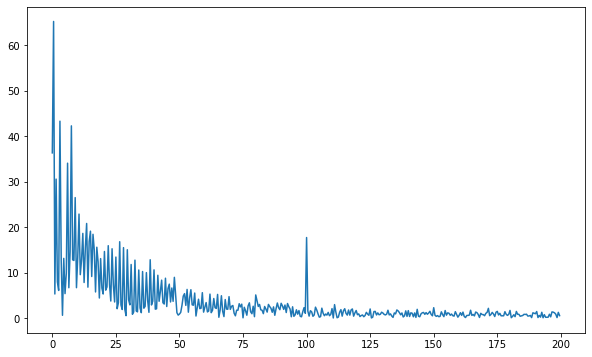

In [55]:
# Frequency Domain Signal after filtering process. Noise removed.
# FFT len is half size of the signal len
# Because of nyquist theorem only half of the sampling frequency can be seen in the sprectrum
fftData = np.abs( fft(ekgFiltered) )
fftLen = int(len(fftData) / 2)
freqs = np.linspace(0,samplingFreq/2, fftLen )

matplotlib.rc('figure', figsize=(10, 6))

plt.figure()
plt.plot( freqs, fftData[0:fftLen] )

plt.figure()
plt.plot( freqs[0:400], fftData[0:400] )

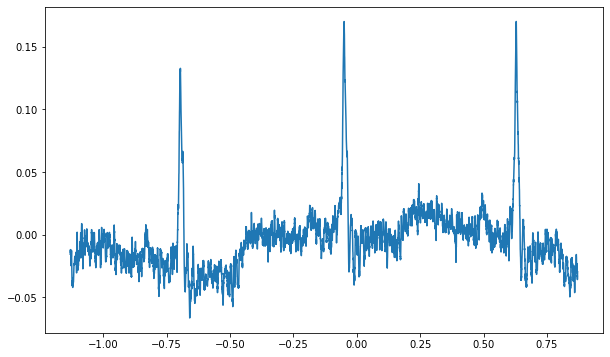

In [56]:
# Time Domain Signal after filtering process. Cleaner signal in comparison to original ECG signal.

matplotlib.rc('figure', figsize=(10, 6))
plt.plot(ekgDF['Time (s)'],ekgFiltered)

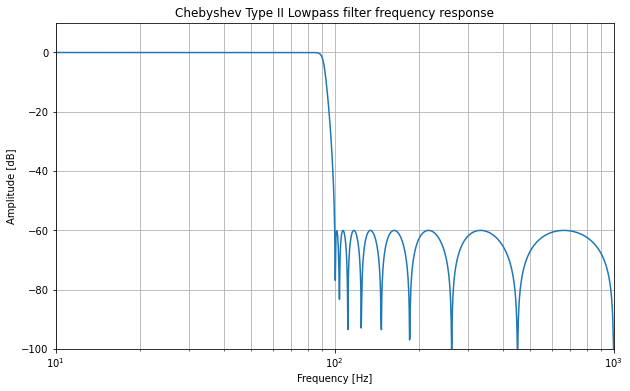

In [57]:
# Filter design to remove high-frequency noise components from the signal. 
# Chebyshev Type II filter, filter coefficients = 17, gain = -60 dB, Lowpass filter frequency band = 0.5 - 200 Hz.


sos2 = signal.iirfilter(17, [0.5, 200], rs=60, btype='bandpass',
                        analog=False, ftype='cheby2', fs=4000,
                        output='sos')
w, h = signal.sosfreqz(sos2, 2000, fs=2000)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
# ax.set_title('Chebyshev Type II bandpass frequency response')
ax.set_title('Chebyshev Type II Lowpass filter frequency response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

In [58]:
## filter out 50 Hz noise
ekgFiltered2 = signal.sosfilt(sos2, ekgFiltered)

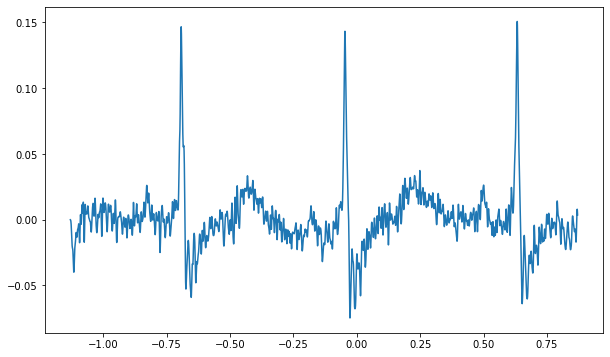

In [59]:
# Time Domain Signal
matplotlib.rc('figure', figsize=(10, 6))
plt.plot(ekgDF['Time (s)'],ekgFiltered2)

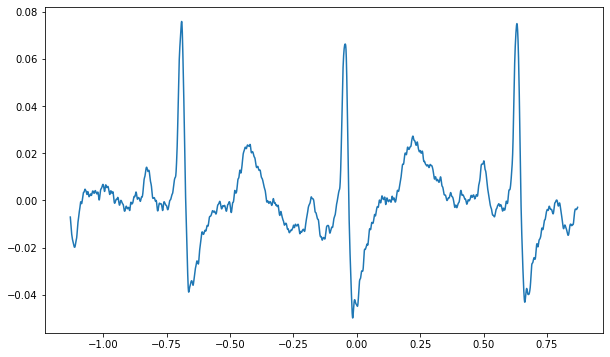

In [60]:
# Now after applying moving average filter, we can extract the each components of the ECG signal.

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

# Time Domain Signal
matplotlib.rc('figure', figsize=(10, 6))
plt.plot(ekgDF['Time (s)'],moving_average(ekgFiltered2, 100))